In [28]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from sklearn.metrics import r2_score
from logistic import logistic as logistic

### Preamble

# add ODYM module directory to system path, relative
MainPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Nk = len(IndexTable.Classification[IndexTable.index.get_loc('Capacity')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('Make')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)

INFO (<ipython-input-28-565c1e628244> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-28-565c1e628244> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 24. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-28-565c1e628244> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-28-565c1e628244> <<mod

## Here we calcualte the EV shares by comparing the global sales to the total vehicle sales 

In [29]:
sales = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/motorEnergysales_passengerCars_Global/passengerCars_motorEnergy_World_2005_2019.xlsx')

In [30]:
sales.set_index('Year', inplace=True)

In [31]:
total = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/motorEnergysales_passengerCars_Global/pc_sales_2019(1)_OICA.xlsx', skiprows=5)

In [32]:
total = total[total['REGIONS/COUNTRIES']== 'ALL COUNTRIES'].reset_index(drop=True)
total = total.melt()
total.dropna(inplace=True)
total.drop(index=[0], inplace=True)

In [33]:
total.rename(columns={'variable': 'Year'}, inplace=True)
total.set_index('Year', inplace=True)

In [34]:
total = total/1000

In [35]:
total

,value
Year,
2005,45407.3
2006,47955.3
2007,50834.5
2008,49978.2
2009,49655
2010,55818.6
2011,57840
2012,60936.4
2013,63429.2


In [36]:
dt_shares = pd.DataFrame(sales['BEV sales'].values/total.value.values)
dt_shares['PHEV'] = pd.DataFrame(sales['PHEV sales'].values/total.value.values)


In [37]:
dt_shares.rename(columns={0: 'BEV', 1:'PHEV'}, inplace=True)

In [38]:
dt_shares['year'] = np.arange(2005,2020)

In [39]:
dt_shares = dt_shares.append({'year':2050, 'BEV':0.35, 'PHEV':0.15}, ignore_index=True)
dt_shares = dt_shares.append({'year':2135, 'BEV':0.70, 'PHEV':0.3}, ignore_index=True)

In [40]:
dt_shares['Scenario'] = 'SD'

In [41]:
dt = dt_shares.copy()

In [42]:
dt['Scenario'] = 'STEP'

In [43]:
dt.loc[15,'BEV'] = 0.175
dt.loc[15,'PHEV'] = 0.075
dt.loc[16,'BEV'] = 0.7
dt.loc[16,'PHEV'] = 0.3

In [44]:
dt_shares = dt_shares.append(dt)

In [45]:
dt_shares

,BEV,PHEV,year,Scenario
0,4.16233e-05,0,2005.0,SD
1,7.08994e-06,0,2006.0,SD
2,1.65242e-05,0,2007.0,SD
3,7.38321e-05,0,2008.0,SD
4,4.59168e-05,0,2009.0,SD
5,0.000140813,6.80777e-06,2010.0,SD
6,0.000677559,0.000156466,2011.0,SD
7,0.000945904,0.000993167,2012.0,SD
8,0.00177489,0.00144381,2013.0,SD
9,0.00297421,0.00202927,2014.0,SD


In [46]:
# Trying logistic
t = np.arange(1950,2136)
dt_fit = np.zeros((2,len(t)))
PHEV = np.zeros((2,len(t)))
for i,s in enumerate(dt_shares['Scenario'].unique()):
    popt, pcov = curve_fit(logistic, dt_shares[dt_shares['Scenario']==s]['year'], dt_shares[dt_shares['Scenario']==s]['BEV'], bounds=([min(dt_shares[dt_shares['Scenario']==s]['year']), 0., 0, 0], [max(dt_shares[dt_shares['Scenario']==s]['year']), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    dt_fit[i,:] = logistic(t, *popt)
    popt, pcov = curve_fit(logistic, dt_shares[dt_shares['Scenario']==s]['year'], dt_shares[dt_shares['Scenario']==s]['PHEV'], bounds=([min(dt_shares[dt_shares['Scenario']==s]['year']), 0., 0, 0], [max(dt_shares[dt_shares['Scenario']==s]['year']), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    PHEV[i,:] = logistic(t, *popt)
    print(*popt)

2049.987763305999 8.009406295761774 3.780837439187976e-18 0.2999826229975432
2061.524891290469 10.507812844587823 1.789842025116882e-20 0.30026659953903817


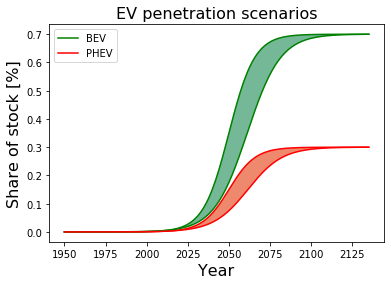

In [47]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
for i,s in enumerate(dt_shares['Scenario'].unique()):
    ax.fill_between(t, dt_fit[0,:], dt_fit[1,:], alpha=0.4)
    ax.fill_between(t, PHEV[0,:], PHEV[1,:], alpha=0.4)
    ax.plot(t, dt_fit[i,:], 'g')
    ax.plot(t, PHEV[i,:], 'r')
    ax.legend(['BEV', 'PHEV'], loc='best',prop={'size':10})
    ax.set_ylabel('Share of stock [%]',fontsize =16)
    ax.set_title('EV penetration scenarios'.format(s), fontsize=16)
    ax.set_xlabel('Year',fontsize =16)

In [48]:
IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items

['STEP', 'SD', 'BAU']

In [51]:
DTArray = np.zeros((NS, Nr, Ng, Nt))
DTArray[0,:,1,:]= dt_fit[1,:101]
DTArray[0,:,3,:]= PHEV[1,:101]
DTArray[0,:,0,:]= 1 - dt_fit[1,:101]-PHEV[1,:101]
DTArray[1,:,1,:]= dt_fit[0,:101]
DTArray[1,:,3,:]= PHEV[0,:101]
DTArray[1,:,0,:]= 1 - dt_fit[0,:101]-PHEV[0,:101]

In [53]:
np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/motorEnergy/motorEnergy_IEA', DTArray)